[*********************100%***********************]  1 of 1 completed

Estimated a (mean reversion speed): 0.2049
Estimated b (long-term mean): 0.4931
Estimated sigma (volatility): 0.1006


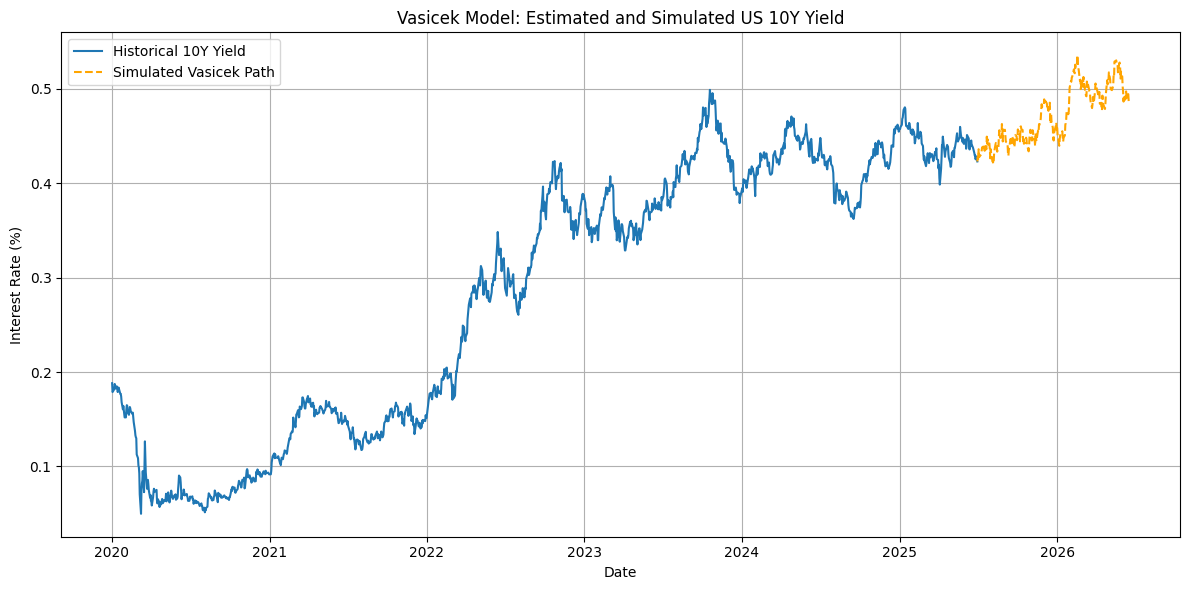

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import LinearRegression

# Step 1: Download historical interest rate data
print("Downloading 10Y US Treasury data...")
data = yf.download("^TNX", start="2020-01-01", end="2025-07-01")

if 'Close' not in data.columns or data.empty:
    raise ValueError("Error: No 'Close' data found for ^TNX.")

# Convert from tenths of a percent to actual %
data = data['Close'] / 10
data = data.dropna()
data.name = 'Rate'

# Step 2: Prepare data for Vasicek model parameter estimation
dt = 1 / 252
r_t = data[:-1].values  # r_t
r_t1 = data[1:].values  # r_{t+1}
dr = (r_t1 - r_t) / dt  # Δr/dt

# Reshape for sklearn
X = r_t.reshape(-1, 1)
y = dr

# Step 3: Linear Regression to estimate a and b
model = LinearRegression()
model.fit(X, y)

a = -model.coef_[0]
ab = model.intercept_
b = ab / a
residuals = y - model.predict(X)
sigma = np.std(residuals) * np.sqrt(dt)

print(f"Estimated a (mean reversion speed): {a.item():.4f}")
print(f"Estimated b (long-term mean): {b.item():.4f}")
print(f"Estimated sigma (volatility): {sigma:.4f}")


# Step 4: Simulate future Vasicek path
T = 1  # 1 year
N = 252
sim_dt = T / N
sim_r = [data.values[-1]]

for _ in range(N):
    dr_sim = a * (b - sim_r[-1]) * sim_dt + sigma * np.sqrt(sim_dt) * np.random.normal()
    sim_r.append(sim_r[-1] + dr_sim)

# Step 5: Plot actual + simulated
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label="Historical 10Y Yield")
future_dates = pd.date_range(data.index[-1], periods=N+1, freq='B')
plt.plot(future_dates, sim_r, '--', label="Simulated Vasicek Path", color="orange")
plt.xlabel("Date")
plt.ylabel("Interest Rate (%)")
plt.title("Vasicek Model: Estimated and Simulated US 10Y Yield")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


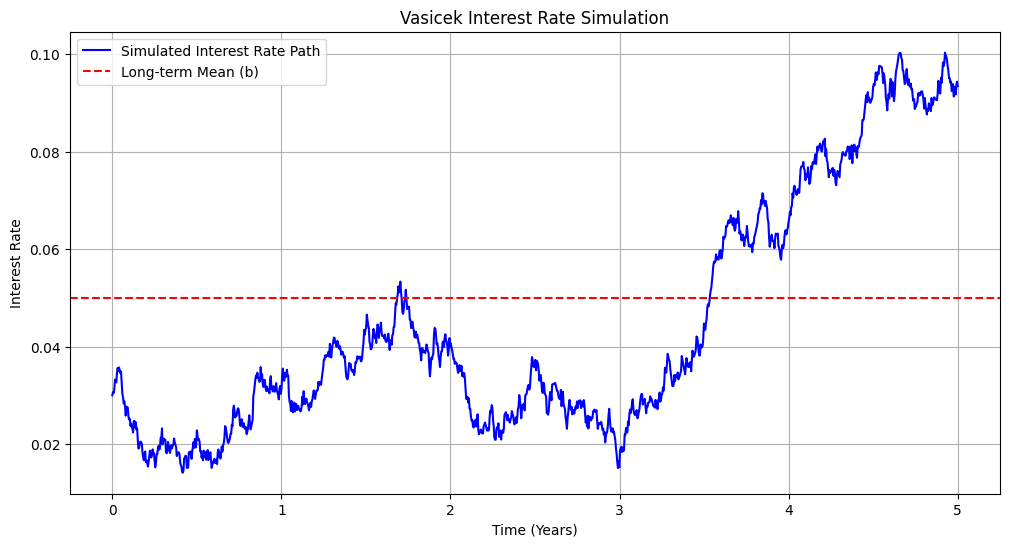

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Vasicek Model
r0 = 0.03       # initial interest rate
a = 0.1         # speed of mean reversion
b = 0.05        # long-term mean level
sigma = 0.02    # volatility
T = 5           # total time in years
dt = 1/252      # time step (daily)
N = int(T / dt) # number of steps
np.random.seed(42)

# Vasicek simulation (single path)
r = np.zeros(N)
r[0] = r0
for t in range(1, N):
    dr = a * (b - r[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
    r[t] = r[t-1] + dr

# Time vector
time = np.linspace(0, T, N)

# Plotting the path
plt.figure(figsize=(12, 6))
plt.plot(time, r, label="Simulated Interest Rate Path", color='blue')
plt.axhline(b, color='red', linestyle='--', label='Long-term Mean (b)')
plt.title("Vasicek Interest Rate Simulation")
plt.xlabel("Time (Years)")
plt.ylabel("Interest Rate")
plt.legend()
plt.grid(True)
plt.show()

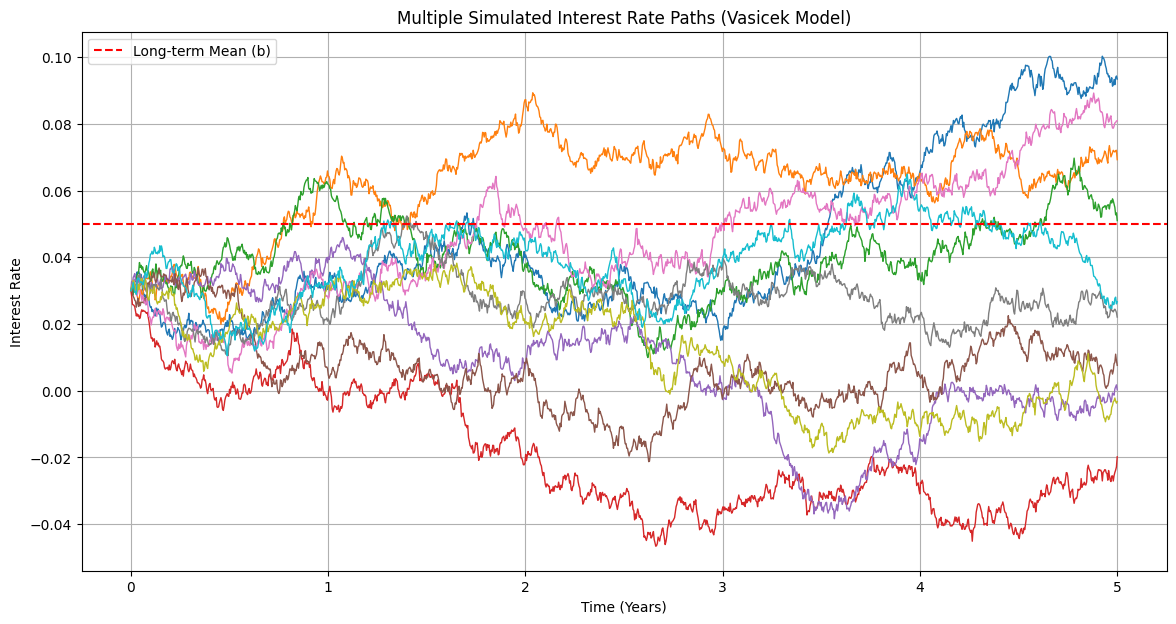

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Vasicek model parameters
r0 = 0.03       # initial interest rate
a = 0.1         # speed of mean reversion
b = 0.05        # long-term mean level
sigma = 0.02    # volatility
T = 5           # total time in years
dt = 1/252      # daily steps
N = int(T / dt) # number of steps
M = 10          # number of simulated paths
np.random.seed(42)

# Simulate multiple paths
r_paths = np.zeros((M, N))
r_paths[:, 0] = r0

for i in range(M):
    for t in range(1, N):
        dr = a * (b - r_paths[i, t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        r_paths[i, t] = r_paths[i, t-1] + dr

# Time vector
time = np.linspace(0, T, N)

# Plot multiple paths
plt.figure(figsize=(14, 7))
for i in range(M):
    plt.plot(time, r_paths[i], lw=1)
plt.axhline(b, color='red', linestyle='--', label='Long-term Mean (b)')
plt.title("Multiple Simulated Interest Rate Paths (Vasicek Model)")
plt.xlabel("Time (Years)")
plt.ylabel("Interest Rate")
plt.grid(True)
plt.legend()
plt.show()


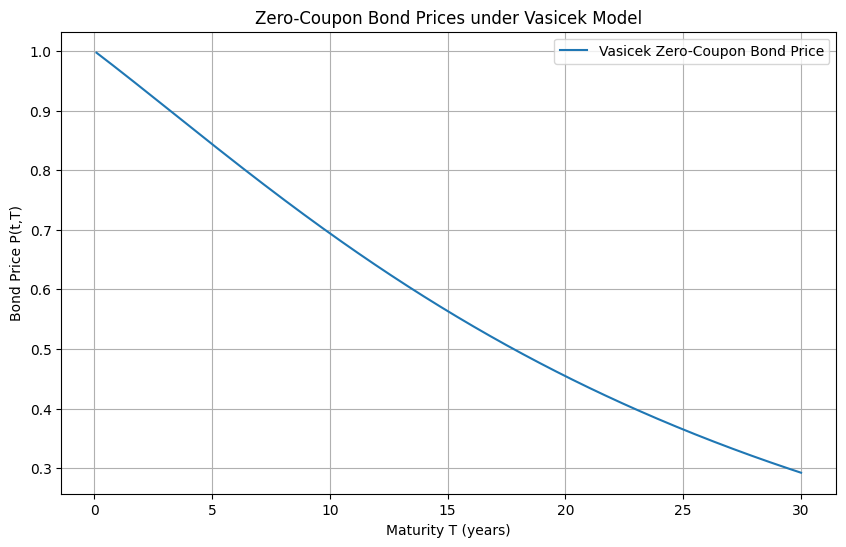

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def vasicek_zero_coupon_price(r_t, t, T, a, b, sigma):
    """Compute the Vasicek zero-coupon bond price P(t,T)"""
    tau = T - t
    B = (1 - np.exp(-a * tau)) / a

    A = np.exp(
        (B - tau) * (a**2 * b - sigma**2 / 2) / a**2
        - (sigma**2 * B**2) / (4 * a)
    )

    return A * np.exp(-B * r_t)

# Parameters
a = 0.1         # speed of mean reversion
b = 0.05        # long-term mean
sigma = 0.01    # volatility
r0 = 0.03       # current short rate
t = 0.0         # current time

# Compute bond prices for various maturities
maturities = np.linspace(0.1, 30, 300)
bond_prices = [vasicek_zero_coupon_price(r0, t, T, a, b, sigma) for T in maturities]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(maturities, bond_prices, label=f'Vasicek Zero-Coupon Bond Price')
plt.xlabel('Maturity T (years)')
plt.ylabel('Bond Price P(t,T)')
plt.title('Zero-Coupon Bond Prices under Vasicek Model')
plt.grid(True)
plt.legend()
plt.show()


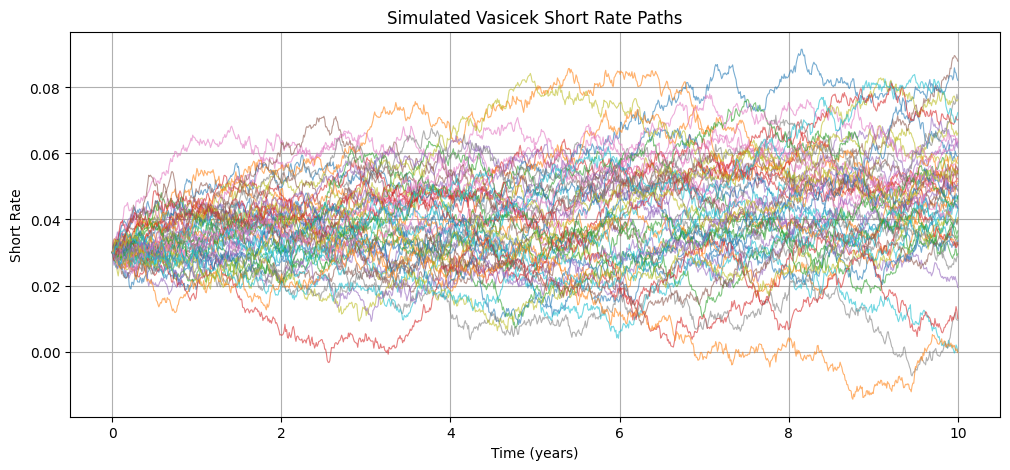

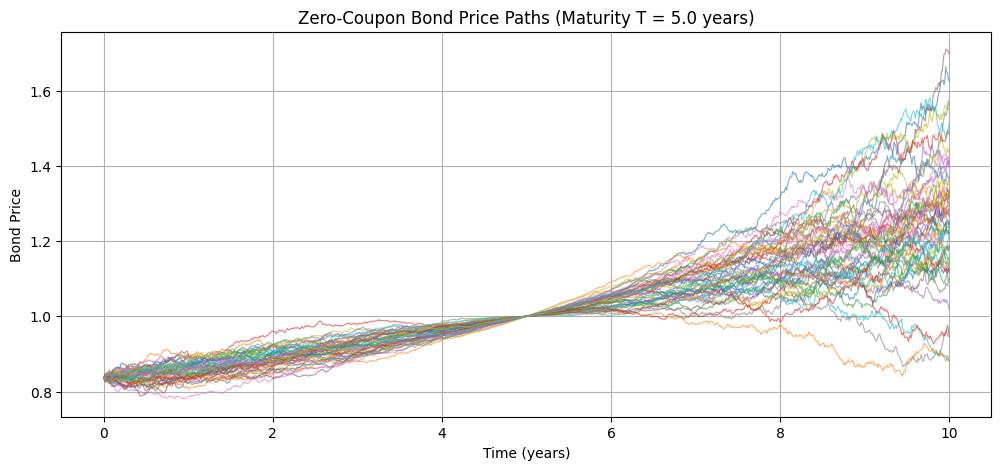

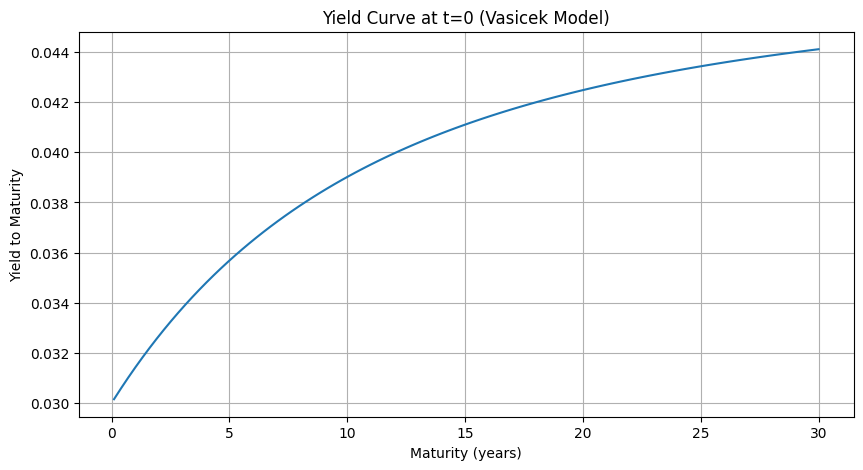

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Vasicek parameters
# -------------------------------
a = 0.15        # mean reversion speed
b = 0.05        # long-term mean
sigma = 0.01    # volatility
r0 = 0.03       # initial short rate

# -------------------------------
# Simulation parameters
# -------------------------------
T_max = 10          # simulation horizon in years
dt = 0.01           # time step
n_steps = int(T_max / dt)
n_paths = 50        # number of simulated paths
times = np.linspace(0, T_max, n_steps)

# -------------------------------
# Vasicek simulation function
# -------------------------------
def simulate_vasicek_paths(r0, a, b, sigma, T, dt, n_paths):
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps))
    rates[:, 0] = r0

    for t in range(1, n_steps):
        dr = a * (b - rates[:, t-1]) * dt + sigma * np.sqrt(dt) * np.random.randn(n_paths)
        rates[:, t] = rates[:, t-1] + dr

    return rates

# -------------------------------
# Bond price function (Vasicek)
# -------------------------------
def vasicek_bond_price(r_t, t, T, a, b, sigma):
    tau = T - t
    B = (1 - np.exp(-a * tau)) / a
    A = np.exp((B - tau)*(a**2 * b - sigma**2 / 2)/a**2 - (sigma**2 * B**2)/(4*a))
    return A * np.exp(-B * r_t)

# -------------------------------
# 1. Simulate interest rate paths
# -------------------------------
rates = simulate_vasicek_paths(r0, a, b, sigma, T_max, dt, n_paths)

# -------------------------------
# 2. Compute bond price over time for fixed maturity
# -------------------------------
maturity = 5.0  # maturity of the zero-coupon bond
bond_prices = np.zeros_like(rates)

for i in range(n_steps):
    t = times[i]
    for j in range(n_paths):
        bond_prices[j, i] = vasicek_bond_price(rates[j, i], t, maturity, a, b, sigma)

# -------------------------------
# Plot 1: Short rate paths
# -------------------------------
plt.figure(figsize=(12, 5))
for i in range(n_paths):
    plt.plot(times, rates[i], lw=0.8, alpha=0.6)
plt.title("Simulated Vasicek Short Rate Paths")
plt.xlabel("Time (years)")
plt.ylabel("Short Rate")
plt.grid(True)
plt.show()

# -------------------------------
# Plot 2: Bond price evolution
# -------------------------------
plt.figure(figsize=(12, 5))
for i in range(n_paths):
    plt.plot(times, bond_prices[i], lw=0.8, alpha=0.6)
plt.title(f"Zero-Coupon Bond Price Paths (Maturity T = {maturity} years)")
plt.xlabel("Time (years)")
plt.ylabel("Bond Price")
plt.grid(True)
plt.show()

# -------------------------------
# Plot 3: Yield Curve at t = 0
# -------------------------------
maturities = np.linspace(0.1, 30, 100)
yields = []

for T in maturities:
    price = vasicek_bond_price(r0, 0, T, a, b, sigma)
    ytm = -np.log(price) / T  # Yield to Maturity (continuously compounded)
    yields.append(ytm)

plt.figure(figsize=(10, 5))
plt.plot(maturities, yields)
plt.title("Yield Curve at t=0 (Vasicek Model)")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield to Maturity")
plt.grid(True)
plt.show()
